In [ ]:
import TimeSliceImport
import numpy as np
import keras
from keras.models import Sequential

from keras.layers import (Dense, Dropout, Activation, Conv1D,Conv2D, Flatten)
from keras.layers import (MaxPooling1D,BatchNormalization,MaxPooling2D, GlobalAveragePooling1D,LSTM)
from keras.optimizers import SGD
from sklearn import (metrics,preprocessing)
import RamanPlotTools as pt
import matplotlib.pyplot as plt
from keras.optimizers import Adam

from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
from ann_visualizer.visualize import ann_viz


/Users/morten/.local/share/virtualenvs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path="/Users/morten/Desktop/SKYP_KYP_SYP/"
start=201
end=1600
points=1000
numClasses=4
types=["PS", "yeast","spore","kleb"]
spectra=TimeSliceImport.importData(path,types)
classes=list(map(lambda x:TimeSliceImport.RamanSample.mappings[x],types))
sortedTypesTuples=sorted(zip(types,classes),key=lambda x:x[1])
sortedTypes=[x[0] for x in sortedTypesTuples]




def makeRandomData():
    trainingSamples, validationSamples = TimeSliceImport.splitData(spectra, 0.25)
    trainingSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points), trainingSamples))
    validationSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points), validationSamples))
    trainingData,trainingClasses,validationData,validationClasses = TimeSliceImport.makeSVMInputData(trainingSpectraList, validationSpectraList)

    oneHotTrainingClasses=keras.utils.to_categorical(trainingClasses,num_classes=numClasses)
    oneHotValidationClasses=keras.utils.to_categorical(validationClasses,num_classes=numClasses)
    return trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses

trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData()

def makePerCellTrainingData():
    trainingSamples, validationSamples = TimeSliceImport.splitData(spectra, 0.25)
    trainingSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points), trainingSamples))
    validationSpectraList = list(map(lambda x: x.interpolatedSpectra(start, end, points), validationSamples))

    trainingData,trainingClasses,validationData,validationClasses = TimeSliceImport.makeMultiDimensionalData(trainingSpectraList=trainingSpectraList,
                                                                                                         validationSpectraList=validationSpectraList,
                                                                                                         normalize=True,
                                                                                                         oneHot=True)
    return trainingData,trainingClasses,validationData,validationClasses



def scalarClassesFromOneHotArray(oneHotArray):
    return np.argmax(oneHotArray,axis=1)

def plotResult(truth,result, score, normalize=False):
    pt.plotResult(scalarClassesFromOneHotArray(result),scalarClassesFromOneHotArray(truth),sortedTypes)
    mtrx = metrics.confusion_matrix(scalarClassesFromOneHotArray(truth),scalarClassesFromOneHotArray(result))
    pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % score, normalize=normalize)

def plotLearning(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training Loss', 'Cross-Validation Loss'])
    plt.show()

def showModel(mode):
    svg=SVG(model_to_dot(model, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))
    display(svg)

Why does binary cross entropy, which appears wrong, work so much better than categorical cross entropy?
Potentially an error in interpreting model.evaluate?


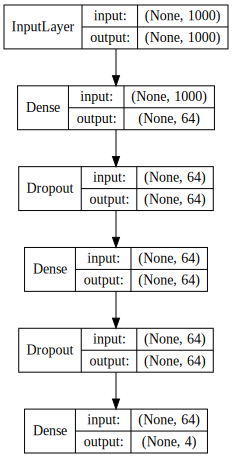

630/630 [==============================] - 0s 53us/step
Score: 0.6507936507936508, SKScore: 0.6507936507936508
0.6507936507936508
630/630 [==============================] - 0s 42us/step
Score: 0.6761904761904762, SKScore: 0.6761904761904762
0.6761904761904762
630/630 [==============================] - 0s 45us/step
Score: 0.7206349206349206, SKScore: 0.7206349206349206
0.7206349206349206
630/630 [==============================] - 0s 45us/step
Score: 0.6682539683485788, SKScore: 0.6682539682539682
0.6682539682539682
630/630 [==============================] - 0s 46us/step
Score: 0.5952380956165374, SKScore: 0.5952380952380952
0.5952380952380952
630/630 [==============================] - 0s 47us/step
Score: 0.7460317465994093, SKScore: 0.746031746031746
0.746031746031746
630/630 [==============================] - 0s 48us/step
Score: 0.58888888907811, SKScore: 0.5888888888888889
0.5888888888888889
630/630 [==============================] - 0s 47us/step
Score: 0.6, SKScore: 0.6
0.6
630/630 [

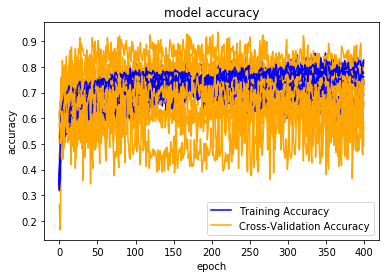

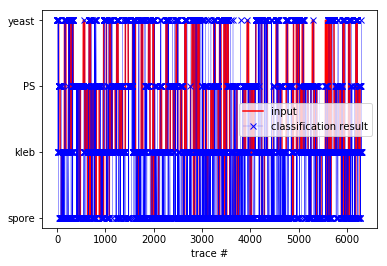

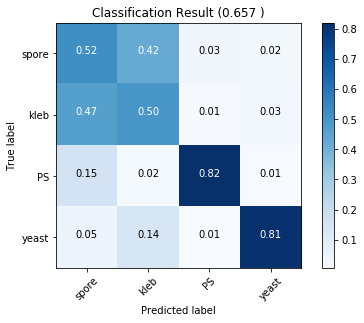

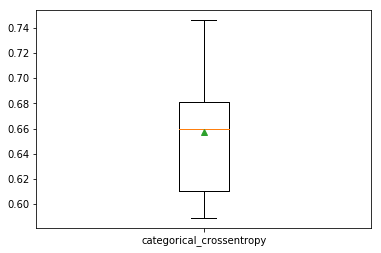

In [3]:
def makeModel(lossFunction="binary_crossentropy", optimizer="SGD"):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=points))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))
    if optimizer == "SGD":
        o = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer == "Adam":
        o = Adam()
    model.compile(loss=lossFunction, optimizer=o, metrics=['accuracy'])
    return model

def runModel(numRepetitions=1):
    
    scores=[]
   
    labels=[]
    
    for l in ["categorical_crossentropy"]:
        runScores=[]
        results=[]
        truths=[]
        labels.append(str(l))
        
        for i in range(numRepetitions):
            model=makeModel(l)
            trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData()
            history = model.fit(trainingData, oneHotTrainingClasses, epochs=400, validation_split=0.15, verbose=0)
            score = model.evaluate(validationData, oneHotValidationClasses)
            prd = model.predict(validationData)
            skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(oneHotValidationClasses),scalarClassesFromOneHotArray(prd))
            print("Score: {}, SKScore: {}".format(score[1], skScore))
            print(skScore)
            results.extend(scalarClassesFromOneHotArray(prd))
            runScores.append(skScore)
            truths.extend(scalarClassesFromOneHotArray(oneHotValidationClasses))
            plt.plot(history.history['acc'], color='blue')
            plt.plot(history.history['val_acc'], color='orange')
        
        avgScore=sum(runScores)/float(len(runScores))
        print("Optimizer: {}, Score: {}".format(l,avgScore))
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
        plt.show()
        scores.append(runScores)
        pt.plotResult(results,truths,sortedTypes)
        mtrx = metrics.confusion_matrix(truths,results)
        pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)
        
    npScores=np.array(scores)
    plt.boxplot(np.transpose(npScores), labels=labels, showmeans=True)
    


model=makeModel()
showModel(model)

runModel(numRepetitions=10)


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


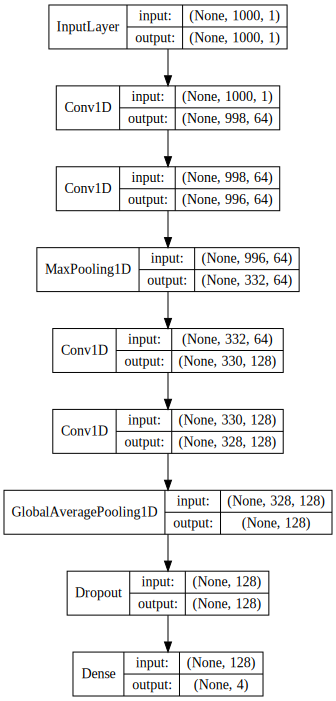

630/630 [==============================] - 1s 2ms/step
Score: 0.8253968244507199, SKScore: 0.6428571428571429
0.6428571428571429
630/630 [==============================] - 1s 2ms/step
Score: 0.8043650793650794, SKScore: 0.5587301587301587
0.5587301587301587
630/630 [==============================] - 1s 2ms/step
Score: 0.8138888881320046, SKScore: 0.6031746031746031
0.6031746031746031
630/630 [==============================] - 1s 2ms/step
Score: 0.8420634930095975, SKScore: 0.6619047619047619
0.6619047619047619
630/630 [==============================] - 1s 2ms/step
Score: 0.815476189530085, SKScore: 0.6190476190476191
0.6190476190476191
630/630 [==============================] - 1s 1ms/step
Score: 0.7976190485651531, SKScore: 0.5619047619047619
0.5619047619047619
630/630 [==============================] - 1s 2ms/step
Score: 0.726984127173348, SKScore: 0.4158730158730159
0.4158730158730159
630/630 [==============================] - 1s 2ms/step
Score: 0.812698413455297, SKScore: 0.5904761

In [ ]:
def makeModel(lossFunction="binary_crossentropy"):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(points, 1)))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='sigmoid'))
    model.compile(loss=lossFunction,
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

epochs=500

def runModel(numRepetitions=1):
    
    scores=[]
   
    labels=[]
    
    for l in ["binary_crossentropy","categorical_crossentropy"]:
        runScores=[]
        results=[]
        truths=[]
        labels.append(str(l))
        
        for i in range(numRepetitions):
            model=makeModel(l)
            trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData()
            #https://stackoverflow.
            # com/questions/43396572/dimension-of-shape-in-conv1d/43399308#43399308
            reshapedTraining = np.expand_dims(trainingData, axis=2)
            reshapedValidation = np.expand_dims(validationData, axis=2)
            
            history = model.fit(reshapedTraining, oneHotTrainingClasses, epochs=epochs, validation_split=0.15, verbose=0)
            score = model.evaluate(reshapedValidation, oneHotValidationClasses)
            prd = model.predict(reshapedValidation)
            skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(oneHotValidationClasses),scalarClassesFromOneHotArray(prd))
            print("Score: {}, SKScore: {}".format(score[1], skScore))
            print(skScore)
            results.extend(scalarClassesFromOneHotArray(prd))
            runScores.append(skScore)
            truths.extend(scalarClassesFromOneHotArray(oneHotValidationClasses))
            plt.plot(history.history['acc'], color='blue')
            plt.plot(history.history['val_acc'], color='orange')
        
        avgScore=sum(runScores)/float(len(runScores))
        print("Optimizer: {}, Score: {}".format(l,avgScore))
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
        plt.show()
        scores.append(runScores)
        pt.plotResult(results,truths,sortedTypes)
        mtrx = metrics.confusion_matrix(truths,results)
        pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)
        
    npScores=np.array(scores)
    plt.boxplot(np.transpose(npScores), labels=labels, showmeans=True)
    


model=makeModel()
showModel(model)
runModel(numRepetitions=10)



Following image classification examle. Todo (maybe): assymetriuc kernel!

In [ ]:
start=201
end=1600
points=500

trainingData,trainingClasses,validationData,validationClasses = makePerCellTrainingData()

inputWidth=trainingData.shape[1]
inputHeight=trainingData.shape[2]
numClasses=trainingClasses.shape[1]

reshapedTraining = np.expand_dims(trainingData, axis=3)
reshapedValidation = np.expand_dims(validationData, axis=3)

def makeModel(lossFunction="categorical_crossentropy"):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(inputWidth,inputHeight,1)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64,(3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(numClasses))
    
    model.add(Activation('softmax'))
    model.compile(loss=lossFunction, optimizer=Adam(), metrics=['accuracy'])
    return model


def runModel(numRepetitions=1):
    
    scores=[]
   
    labels=[]
    
    for l in ["binary_crossentropy","categorical_crossentropy"]:
        runScores=[]
        results=[]
        truths=[]
        labels.append(str(l))
        
        for i in range(numRepetitions):
            model=makeModel(l)
            
            trainingData, oneHotTrainingClasses, validationData, oneHotValidationClasses=makeRandomData()
            #https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d/43399308#43399308
            reshapedTraining = np.expand_dims(trainingData, axis=2)
            reshapedValidation = np.expand_dims(validationData, axis=2)
            
            history = model.fit(reshapedTraining, oneHotTrainingClasses, epochs=400, validation_split=0.2, verbose=1)
            score = model.evaluate(reshapedValidation, oneHotValidationClasses)
            prd = model.predict(reshapedValidation)
            skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(oneHotValidationClasses),scalarClassesFromOneHotArray(prd))
            print("Score: {}, SKScore: {}".format(score[1], skScore))
            print(skScore)
            results.extend(scalarClassesFromOneHotArray(prd))
            runScores.append(skScore)
            truths.extend(scalarClassesFromOneHotArray(oneHotValidationClasses))
            plt.plot(history.history['acc'], color='blue')
            plt.plot(history.history['val_acc'], color='orange')
        
        avgScore=sum(runScores)/float(len(runScores))
        print("Optimizer: {}, Score: {}".format(l,avgScore))
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
        plt.show()
        scores.append(runScores)
        pt.plotResult(results,truths,sortedTypes)
        mtrx = metrics.confusion_matrix(truths,results)
        pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)
        
    npScores=np.array(scores)
    plt.boxplot(np.transpose(npScores), labels=labels, showmeans=True)
    


model=makeModel()
showModel(model)
runModel(numRepetitions=5)


In [ ]:
def makeModel(lossFunction="categorical_crossentropy", dropOut=0.0, recurrentDropout=0.0, nodes=32):
    
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(LSTM(nodes, return_sequences=True,
               input_shape=(timesteps, data_dim), dropout=dropOut))  # returns a sequence of vectors of dimension nodes
    model.add(LSTM(nodes, return_sequences=True,dropout=dropOut))  # returns a sequence of vectors of dimension nodes
    model.add(LSTM(nodes,dropout=dropOut))  # return a single vector of dimension nodes
    model.add(Dense(numClasses, activation='softmax'))
    model.compile(loss=lossFunction, optimizer='rmsprop',metrics=['accuracy'])
    return model

trainingData,trainingClasses,validationData,validationClasses = makePerCellTrainingData()

print(trainingData.shape)
numClasses=trainingClasses.shape[1]
data_dim = trainingData.shape[2]
timesteps = trainingData.shape[1]
epochs=500
numRepetitions=10

model = makeModel()
showModel(model)

scores=[]
labels=[]
    
for l in [16,32,64,128]:
    runScores=[]
    results=[]
    truths=[]
    labels.append(str(l))
    
    for i in range(numRepetitions):
        model=makeModel(nodes=l)
                
        history = model.fit(trainingData, trainingClasses, epochs=epochs, validation_split=0.1, verbose=0)
        score = model.evaluate(validationData, validationClasses)
        prd = model.predict(validationData)
        skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(validationClasses),scalarClassesFromOneHotArray(prd))
        print("Score: {}, SKScore: {}".format(score[1], skScore))
        print(skScore)
        results.extend(scalarClassesFromOneHotArray(prd))
        runScores.append(skScore)
        truths.extend(scalarClassesFromOneHotArray(validationClasses))
        plt.plot(history.history['acc'], color='blue')
        plt.plot(history.history['val_acc'], color='orange')
    
    avgScore=sum(runScores)/float(len(runScores))
    print("Parameter: {}, Score: {}".format(l,avgScore))
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
    plt.show()
    scores.append(runScores)
    pt.plotResult(results,truths,sortedTypes)
    mtrx = metrics.confusion_matrix(truths,results)
    pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)
    
npScores=np.array(scores)
plt.boxplot(np.transpose(npScores), labels=labels, showmeans=True)
plt.title("Nodes")
plt.show()


for l in [0,0.2,0.4,0.6]:
    runScores=[]
    results=[]
    truths=[]
    labels.append(str(l))
    
    for i in range(numRepetitions):
        model=makeModel(dropOut=l)
                
        history = model.fit(trainingData, trainingClasses, epochs=epochs, validation_split=0.1, verbose=0)
        score = model.evaluate(validationData, validationClasses)
        prd = model.predict(validationData)
        skScore=metrics.accuracy_score(scalarClassesFromOneHotArray(validationClasses),scalarClassesFromOneHotArray(prd))
        print("Score: {}, SKScore: {}".format(score[1], skScore))
        print(skScore)
        results.extend(scalarClassesFromOneHotArray(prd))
        runScores.append(skScore)
        truths.extend(scalarClassesFromOneHotArray(validationClasses))
        plt.plot(history.history['acc'], color='blue')
        plt.plot(history.history['val_acc'], color='orange')
    
    avgScore=sum(runScores)/float(len(runScores))
    print("Parameter: {}, Score: {}".format(l,avgScore))
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Accuracy', 'Cross-Validation Accuracy'])
    plt.show()
    scores.append(runScores)
    pt.plotResult(results,truths,sortedTypes)
    mtrx = metrics.confusion_matrix(truths,results)
    pt.plotConfusionMatrix(mtrx,sortedTypes,"Classification Result (%.03g )" % avgScore, normalize=True)
    
npScores=np.array(scores)
plt.boxplot(np.transpose(npScores), labels=labels, showmeans=True)
plt.title("Dropout")


LSTM stateful
